# Example Sheet 2

## Pre-Amble

In [1]:
from itertools import combinations
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

In [2]:
def plot_contours(ax, clf, X, x_idx, y_idx, h=.02, **params):
    x_min, x_max = X[:, x_idx].min() - 1, X[:, x_idx].max() + 1
    y_min, y_max = X[:, y_idx].min() - 1, X[:, y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_predict = np.tile(np.mean(X, axis=0), (xx.shape[0]*xx.shape[1],1))
    X_predict[:, x_idx] = xx.ravel()
    X_predict[:, y_idx] = yy.ravel()
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary(ax, clf, X, y, classes, x_idx, y_idx, h=.02, colourmap=plt.cm.viridis):
    x_min, x_max = X[:, x_idx].min() - 1, X[:, x_idx].max() + 1
    y_min, y_max = X[:, y_idx].min() - 1, X[:, y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_predict = np.tile(np.mean(X, axis=0), (xx.shape[0]*xx.shape[1],1))
    X_predict[:, x_idx] = xx.ravel()
    X_predict[:, y_idx] = yy.ravel()
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=colourmap, alpha=0.8)
    scatter = ax.scatter(X[:,x_idx], X[:,y_idx], c=y, cmap=colourmap, s=20, edgecolors='k')
    handles, labels = scatter.legend_elements()
    legend1 = ax.legend(handles, classes, title="Classes")
    ax.add_artist(legend1)
    return ax

## Question 1: Original Dataset

In [3]:
penguins_df = sns.load_dataset("penguins").drop(columns=["island", "sex"])
display(penguins_df.head(5))
display(penguins_df.describe(include=["float", "int"]))
display(penguins_df.describe(include=["object"]))

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


,species
count,344
unique,3
top,Adelie
freq,152


In [4]:
null_idx = penguins_df.isnull().any(axis=1)
print("Number of null rows with any null values:", null_idx.sum())

Number of null rows with any null values: 2


In [5]:
penguins_df = penguins_df[~null_idx].reset_index().drop(columns=["index"])
penguins_df.head(5)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,36.7,19.3,193.0,3450.0
4,Adelie,39.3,20.6,190.0,3650.0


In [213]:
X = np.array(penguins_df.drop(columns=["species"]))
label_ec = LabelEncoder()
y = label_ec.fit_transform(penguins_df["species"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [214]:
lr_clf = LogisticRegression()
lr_cv = GridSearchCV(lr_clf, param_grid={}, cv=5)
lr_cv.fit(X_train, y_train)
lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")
lr_results

/tmp/ipykernel_5907/631065594.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012761,0.005993,0.000858,0.000163,{},1.0,0.981818,0.981818,0.981481,0.981481,0.98532,0.007342,1.0


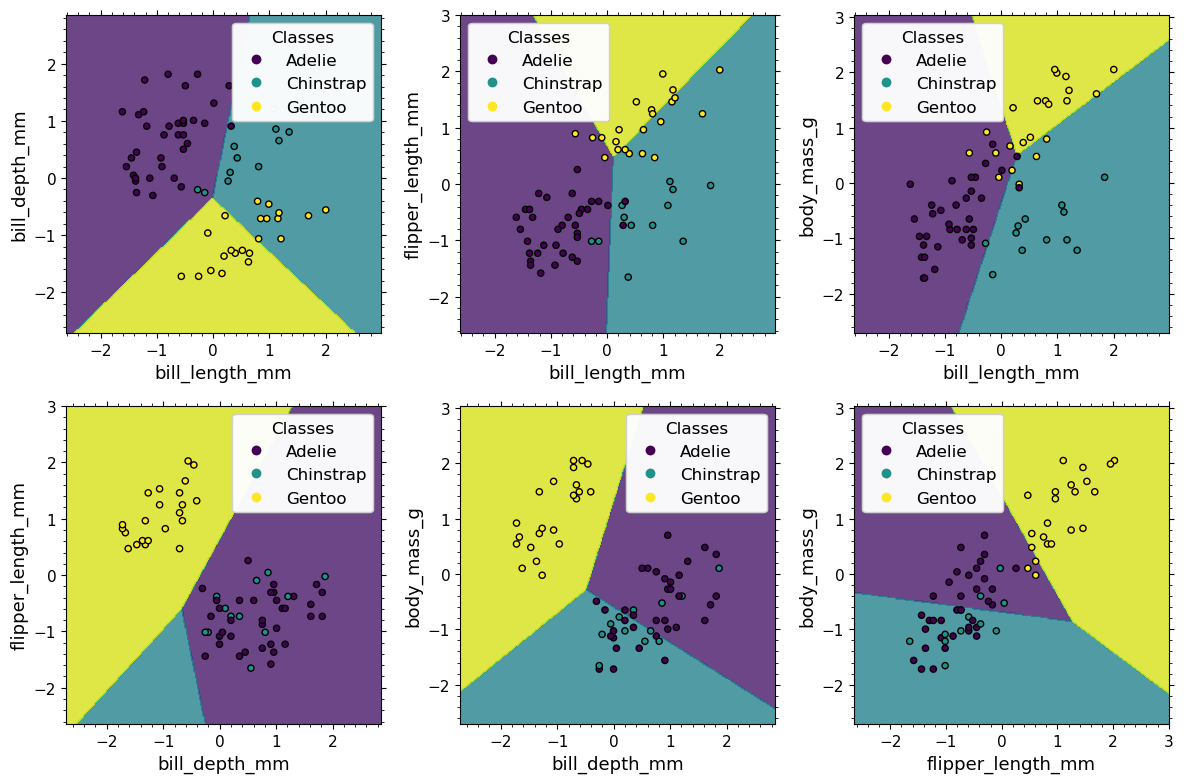

In [215]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lr_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

In [216]:
lr_cv.best_estimator_.intercept_

array([ 0.38688771, -0.09504346, -0.29184426])

In [217]:
lr_cv.best_estimator_.coef_

array([[-2.56107609,  1.33523013, -0.48114481,  0.20535615],
       [ 2.22487357,  0.34673597, -0.68320155, -1.33114415],
       [ 0.33620252, -1.6819661 ,  1.16434637,  1.125788  ]])

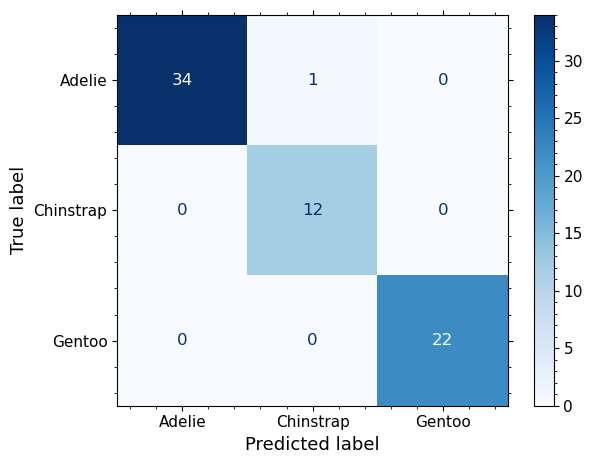

In [218]:
ConfusionMatrixDisplay.from_estimator(lr_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Nearest Neighbours

In [219]:
knn_clf = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_clf, param_grid={"n_neighbors":[2, 3, 4, 5, 7, 10, 15, 20, 30, 40]}, cv=5)
knn_cv.fit(X_train, y_train)
knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")
knn_results

/tmp/ipykernel_5907/1387840006.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000906,0.000344,0.006086,0.001375,2.0,{'n_neighbors': 2},0.981818,0.981818,0.963636,0.962963,0.962963,0.970640,0.009130,10.0
1,0.003236,0.003681,0.015505,0.008573,3.0,{'n_neighbors': 3},1.000000,0.981818,0.981818,0.981481,0.962963,0.981616,0.011713,8.0
2,0.001255,0.000513,0.010053,0.004973,4.0,{'n_neighbors': 4},1.000000,0.981818,0.963636,0.981481,0.981481,0.981684,0.011500,5.0
3,0.001156,0.000337,0.006644,0.000854,5.0,{'n_neighbors': 5},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
4,0.001011,0.000267,0.008045,0.002686,7.0,{'n_neighbors': 7},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
5,0.001364,0.000939,0.006476,0.001482,10.0,{'n_neighbors': 10},1.000000,0.981818,0.963636,0.981481,0.981481,0.981684,0.011500,5.0
6,0.001091,0.000601,0.005131,0.000853,15.0,{'n_neighbors': 15},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
7,0.000841,0.000139,0.006166,0.001980,20.0,{'n_neighbors': 20},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
8,0.000824,0.000224,0.006151,0.002286,30.0,{'n_neighbors': 30},1.000000,0.981818,0.963636,0.981481,0.981481,0.981684,0.011500,5.0
9,0.000698,0.000207,0.005257,0.000995,40.0,{'n_neighbors': 40},0.981818,0.981818,0.981818,0.944444,0.981481,0.974276,0.014916,9.0


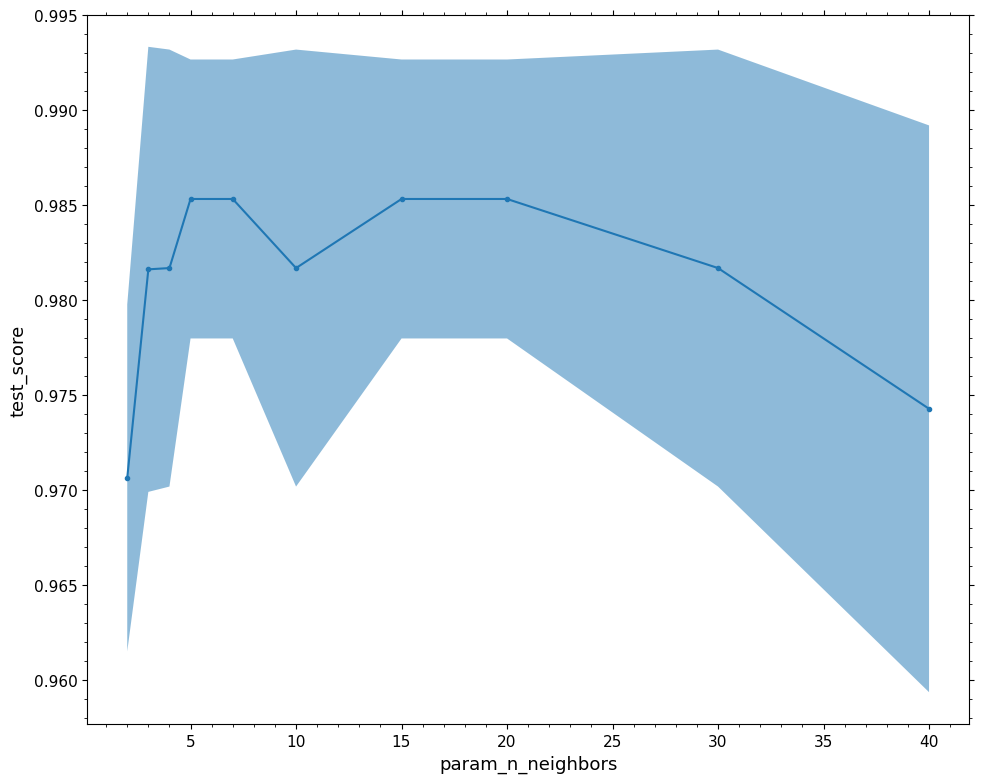

In [220]:
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.plot(knn_results["param_n_neighbors"], knn_results["mean_test_score"], marker=".")
ax.fill_between(knn_results["param_n_neighbors"], knn_results["mean_test_score"] - knn_results["std_test_score"],
                knn_results["mean_test_score"] + knn_results["std_test_score"], alpha=.5)
ax.set_xlabel("param_n_neighbors")
ax.set_ylabel("test_score")
plt.show()

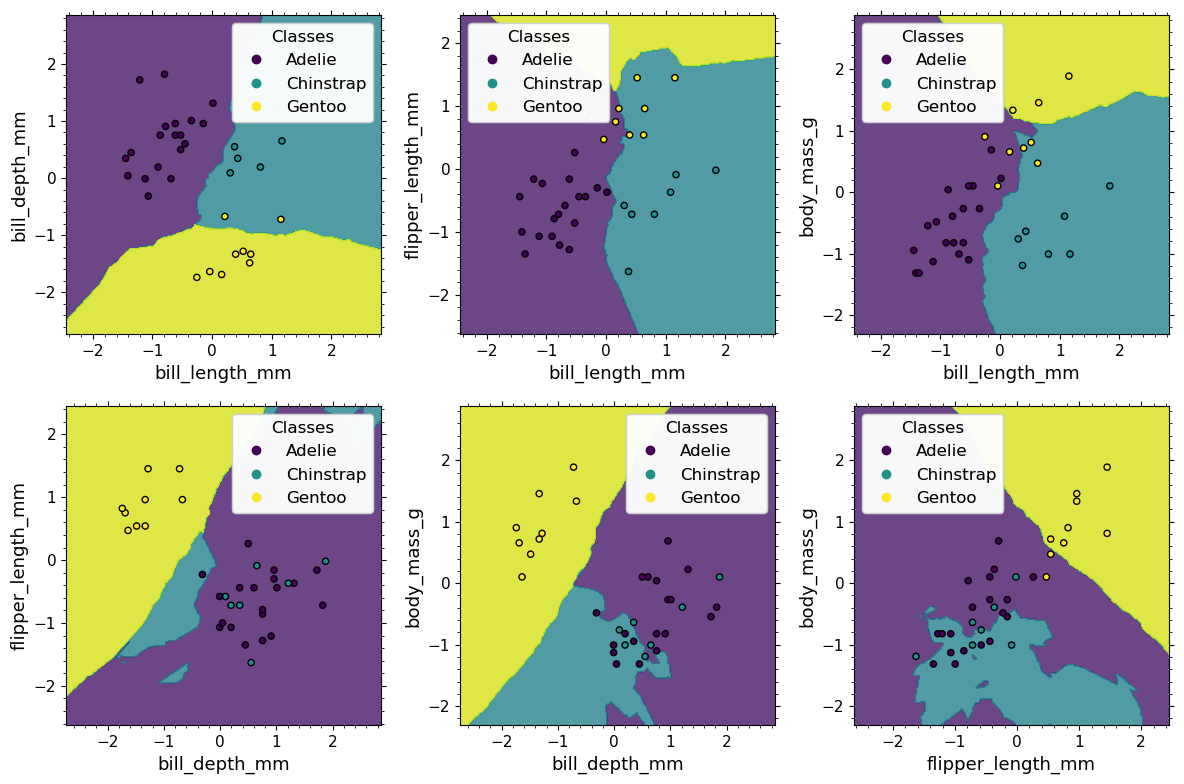

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], knn_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

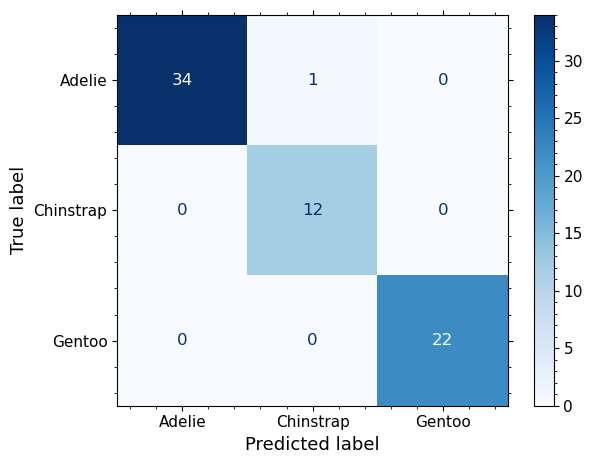

In [221]:
ConfusionMatrixDisplay.from_estimator(knn_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Support Vector Machine

In [222]:
svm_clf = SVC()
svm_cv = GridSearchCV(svm_clf, param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=5)
svm_cv.fit(X_train, y_train)
svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
svm_results

/tmp/ipykernel_5907/766811450.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003100,0.001881,0.002220,0.001576,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,8.0
1,0.002863,0.000728,0.001836,0.001126,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.909091,0.890909,0.818182,0.851852,0.907407,0.875488,0.035294,15.0
2,0.002992,0.000743,0.001939,0.000598,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,8.0
3,0.001481,0.000383,0.000837,0.000231,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",1.000000,0.981818,0.981818,1.000000,0.981481,0.989024,0.008963,4.0
4,0.002006,0.000521,0.001238,0.000449,1.0,poly,"{'C': 1.0, 'kernel': 'poly'}",1.000000,0.981818,0.890909,0.962963,0.981481,0.963434,0.038107,14.0
5,0.004249,0.001757,0.001488,0.000227,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,8.0
6,0.001900,0.000763,0.001306,0.000785,10.0,linear,"{'C': 10.0, 'kernel': 'linear'}",1.000000,1.000000,0.981818,0.981481,1.000000,0.992660,0.008990,3.0
7,0.001699,0.000959,0.001203,0.000930,10.0,poly,"{'C': 10.0, 'kernel': 'poly'}",0.981818,0.981818,0.927273,0.944444,1.000000,0.967071,0.026889,13.0
8,0.001785,0.000820,0.001134,0.000684,10.0,rbf,"{'C': 10.0, 'kernel': 'rbf'}",1.000000,0.981818,0.981818,0.981481,1.000000,0.989024,0.008963,4.0
9,0.001755,0.001433,0.000739,0.000433,100.0,linear,"{'C': 100.0, 'kernel': 'linear'}",1.000000,0.981818,0.963636,0.981481,1.000000,0.985387,0.013625,6.0


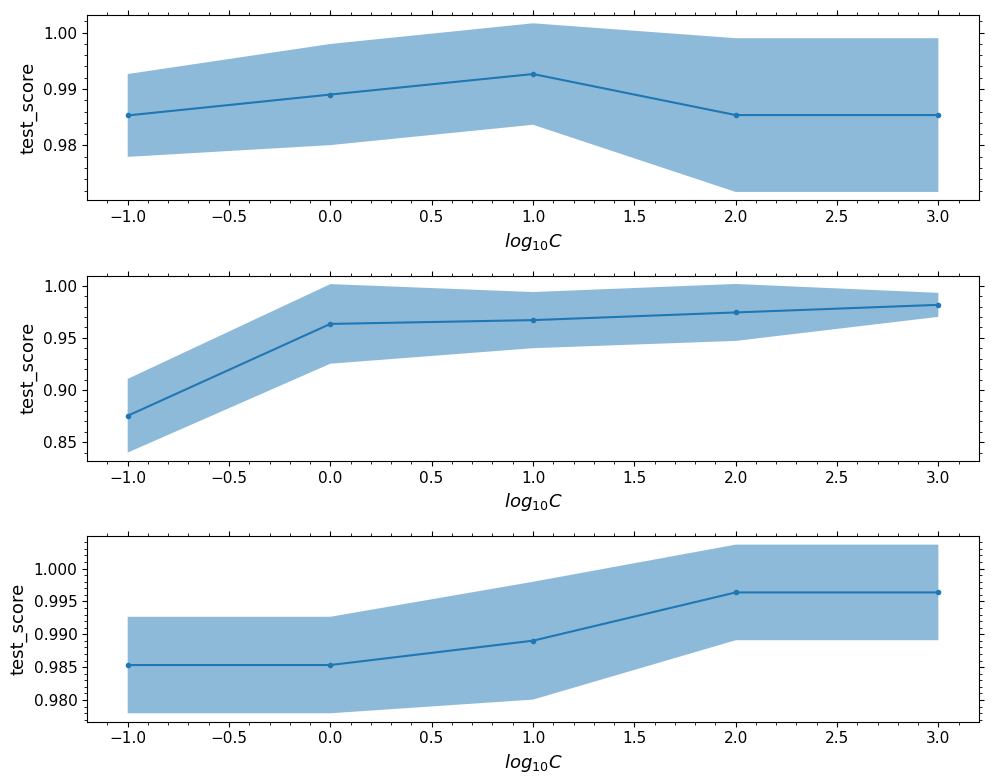

In [223]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))
for idx, kernel in enumerate(["linear", "poly", "rbf"]):
    svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
    ax[idx].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
    ax[idx].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                    svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
    ax[idx].set_xlabel("$log_{10} C$")
    ax[idx].set_ylabel("test_score")
    ax[idx].set_title("")
plt.show()

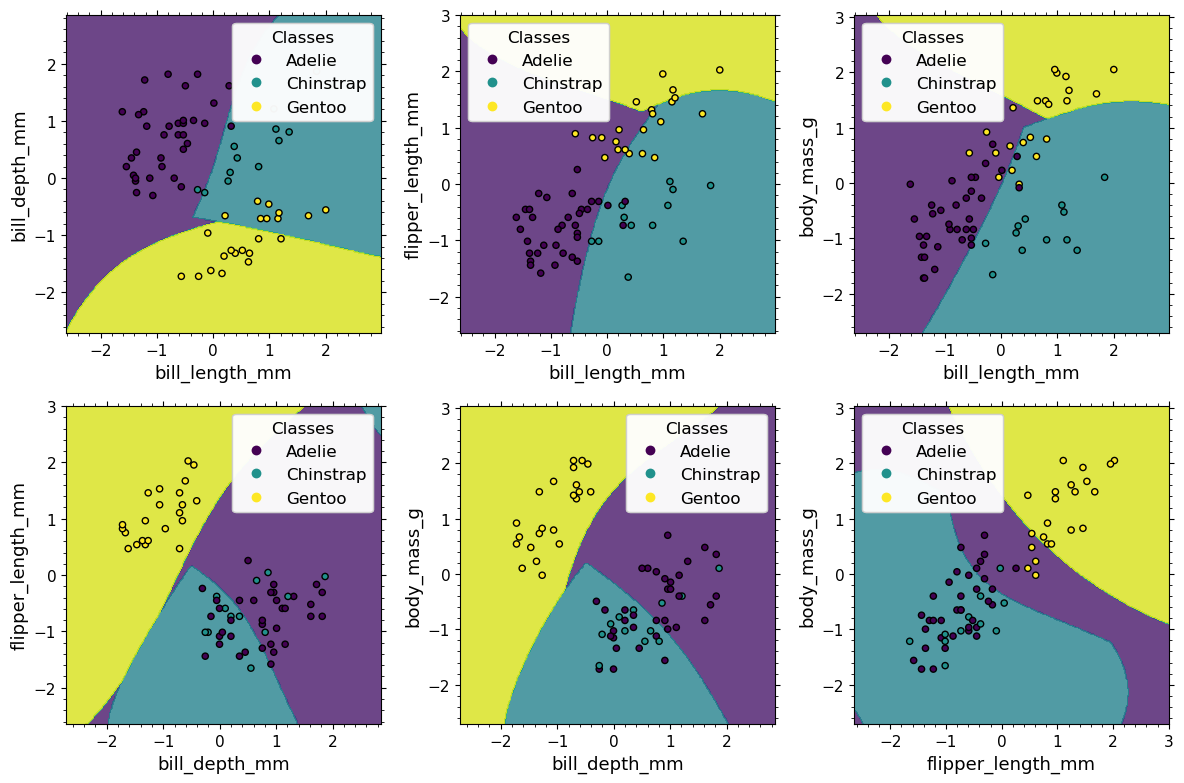

In [224]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], svm_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

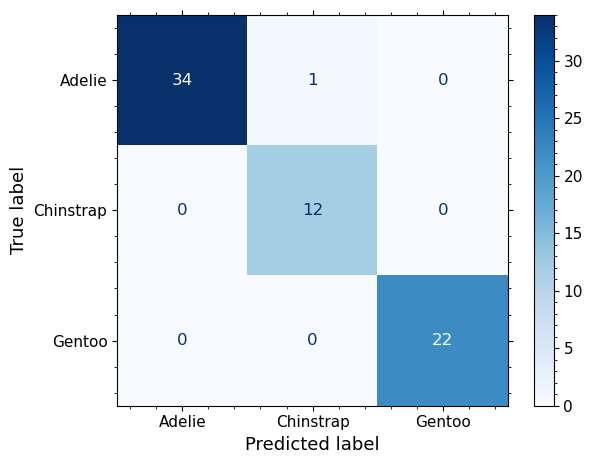

In [225]:
ConfusionMatrixDisplay.from_estimator(svm_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Linear Discriminant Analysis

In [226]:
lda_clf = LinearDiscriminantAnalysis()
lda_cv = GridSearchCV(lda_clf, param_grid={}, cv=5)
lda_cv.fit(X_train, y_train)
lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")
lda_results

/tmp/ipykernel_5907/2525302351.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005255,0.004285,0.001471,0.000642,{},1.0,0.981818,0.981818,1.0,0.981481,0.989024,0.008963,1.0


In [227]:
lda_cv.best_estimator_.intercept_

array([ -7.58496179,  -8.09165386, -14.27324798])

In [228]:
lda_cv.best_estimator_.coef_

array([[ -4.26337096,   7.06649511,  -4.31759276,  -2.22401661],
       [  5.85354892,   4.63122019,  -3.39777168,  -5.98514911],
       [  1.65101279, -10.68377984,   6.84273242,   5.87281463]])

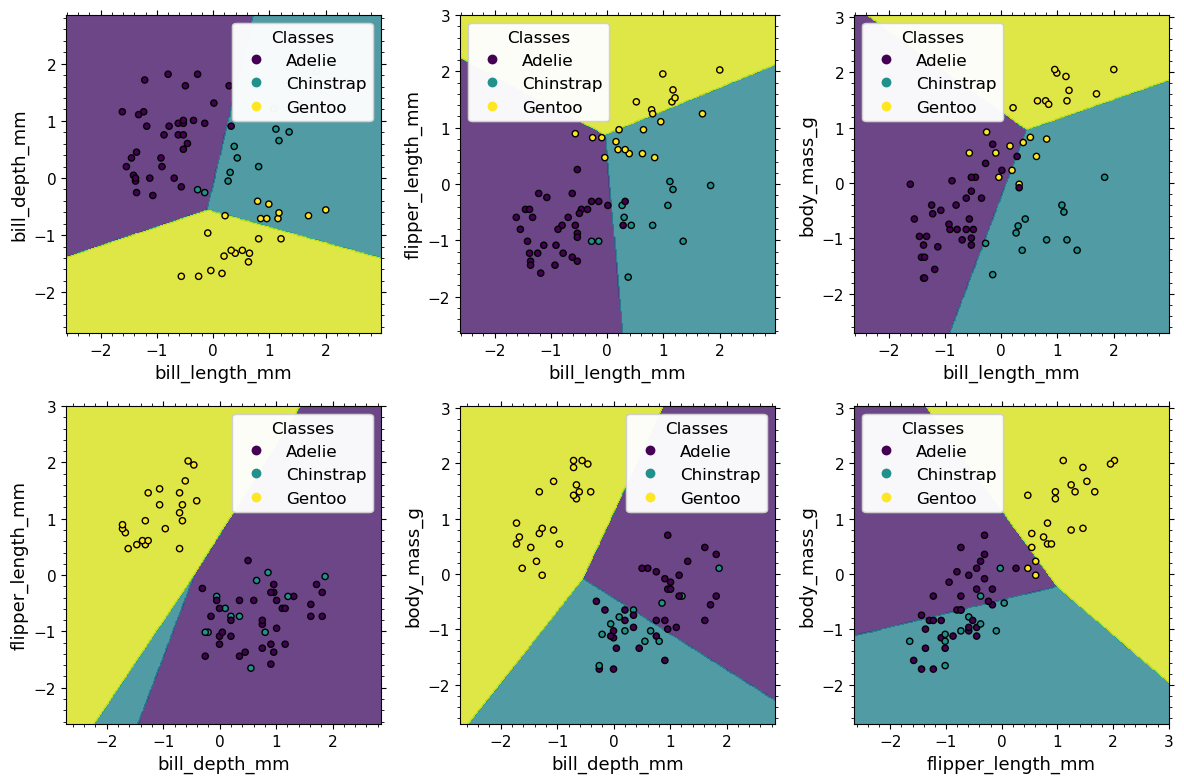

In [229]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

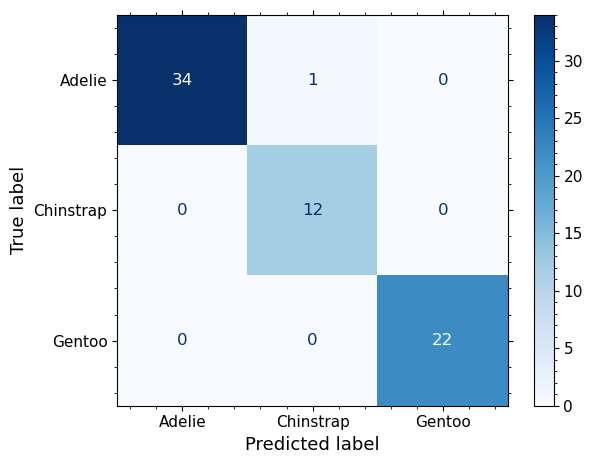

In [230]:
ConfusionMatrixDisplay.from_estimator(lda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Quadratic Discriminant Analysis

In [231]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_cv = GridSearchCV(qda_clf, param_grid={}, cv=5)
qda_cv.fit(X_train, y_train)
qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")
qda_results

/tmp/ipykernel_5907/1998898688.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00349,0.002466,0.001459,0.000506,{},1.0,0.981818,0.981818,0.981481,1.0,0.989024,0.008963,1.0


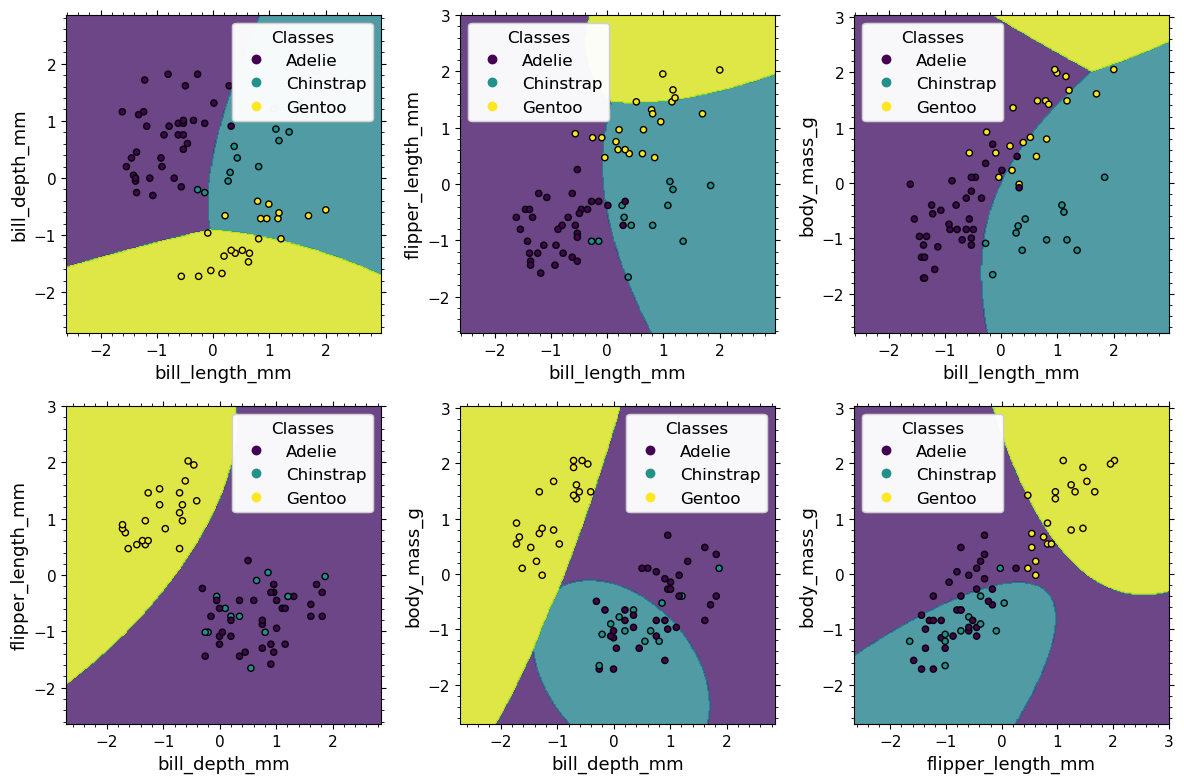

In [232]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], qda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

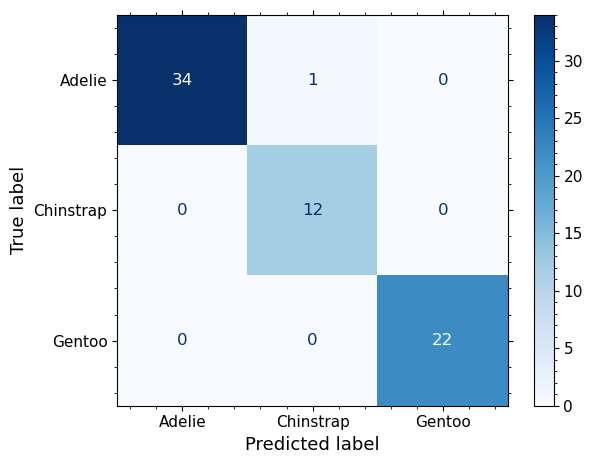

In [233]:
ConfusionMatrixDisplay.from_estimator(qda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

## Question 1: Dataset with Outliers

In [234]:
X = np.array(penguins_df.drop(columns=["species"]))
label_ec = LabelEncoder()
y = label_ec.fit_transform(penguins_df["species"])

In [235]:
g = np.random.default_rng(seed=42)

#outliers_X = X[g.choice(range(len(X)), 10), :] + np.array(5*penguins_df.describe(include=["float", "int"]).loc["std"]).reshape((1,4))*g.choice([-1,1], (10,4))
#outliers_y = g.choice([0,1,2], 10)

rnd_idx = g.choice(range(len(X)), 20)
outliers_X = X[rnd_idx, :] + g.multivariate_normal([0,0,0,0], np.diag(np.array(0.1*penguins_df.describe(include=["float", "int"]).loc["std"])), 20)
outliers_y = (y[rnd_idx] + 1) % 3

In [236]:
X = np.vstack([X, outliers_X])
y = np.hstack([y, outliers_y])

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [238]:
lr_clf = LogisticRegression()
lr_cv = GridSearchCV(lr_clf, param_grid={}, cv=5)
lr_cv.fit(X_train, y_train)
lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")
lr_results

/tmp/ipykernel_5907/631065594.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0114,0.002666,0.001336,0.000831,{},0.896552,0.913793,0.965517,0.931034,0.894737,0.920327,0.026152,1.0


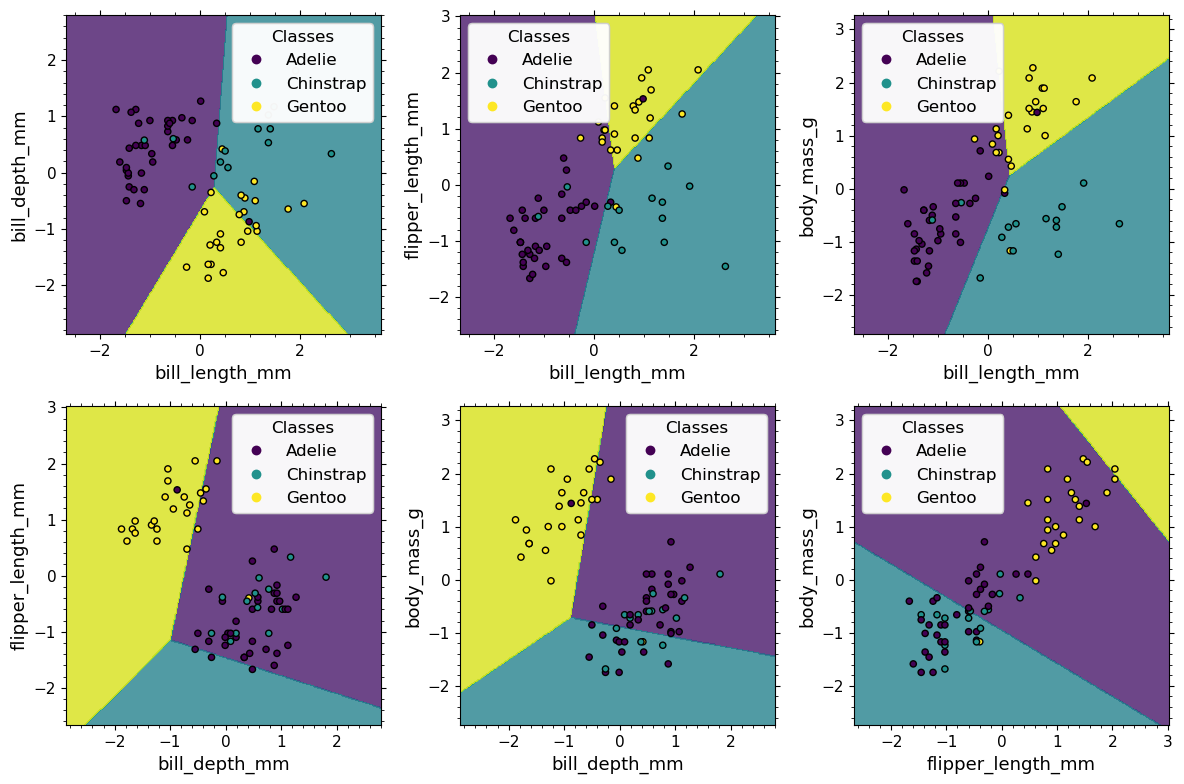

In [239]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lr_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

In [240]:
lr_cv.best_estimator_.intercept_

array([ 0.85651212, -0.54998296, -0.30652916])

In [241]:
lr_cv.best_estimator_.coef_

array([[-2.16697658,  0.69290128,  0.23100534,  0.4722398 ],
       [ 1.76795967,  0.3550253 , -0.82703241, -1.22702222],
       [ 0.39901692, -1.04792659,  0.59602707,  0.75478242]])

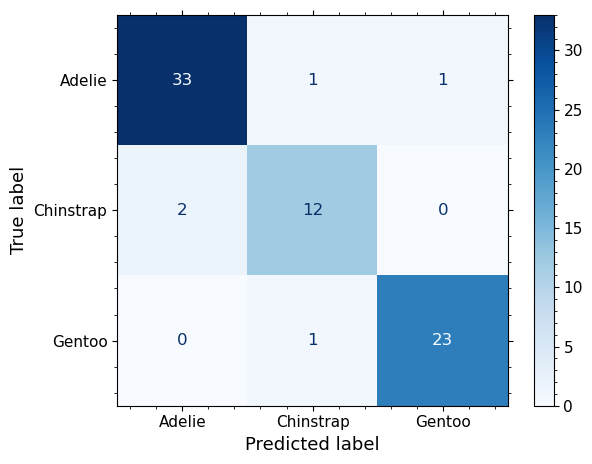

In [242]:
ConfusionMatrixDisplay.from_estimator(lr_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Nearest Neighbours

In [243]:
knn_clf = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_clf, param_grid={"n_neighbors":[2, 3, 4, 5, 7, 10, 15, 20, 30, 40]}, cv=5)
knn_cv.fit(X_train, y_train)
knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")
knn_results

/tmp/ipykernel_5907/1387840006.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002030,0.001389,0.010499,0.004727,2.0,{'n_neighbors': 2},0.879310,0.879310,0.879310,0.862069,0.824561,0.864912,0.021252,10.0
1,0.000820,0.000259,0.006626,0.002930,3.0,{'n_neighbors': 3},0.896552,0.948276,0.931034,0.931034,0.877193,0.916818,0.025980,9.0
2,0.001589,0.000812,0.008697,0.003311,4.0,{'n_neighbors': 4},0.931034,0.948276,0.931034,0.913793,0.894737,0.923775,0.018158,3.0
3,0.000641,0.000078,0.007114,0.002396,5.0,{'n_neighbors': 5},0.913793,0.965517,0.948276,0.931034,0.894737,0.930672,0.024902,1.0
4,0.001112,0.000477,0.005518,0.001509,7.0,{'n_neighbors': 7},0.931034,0.948276,0.965517,0.913793,0.894737,0.930672,0.024902,1.0
5,0.000906,0.000649,0.005411,0.001706,10.0,{'n_neighbors': 10},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
6,0.000939,0.000440,0.004922,0.000812,15.0,{'n_neighbors': 15},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
7,0.000642,0.000066,0.004834,0.001063,20.0,{'n_neighbors': 20},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
8,0.000979,0.000562,0.006048,0.002024,30.0,{'n_neighbors': 30},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
9,0.000657,0.000050,0.004849,0.000495,40.0,{'n_neighbors': 40},0.913793,0.948276,0.948276,0.896552,0.894737,0.920327,0.023770,8.0


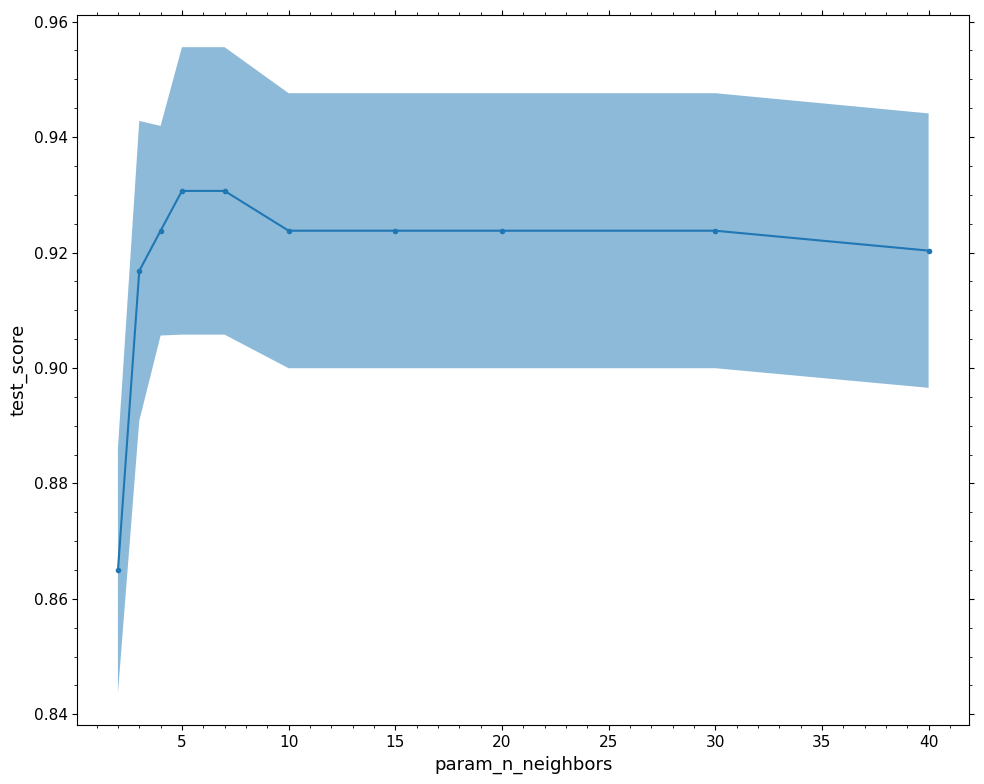

In [244]:
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.plot(knn_results["param_n_neighbors"], knn_results["mean_test_score"], marker=".")
ax.fill_between(knn_results["param_n_neighbors"], knn_results["mean_test_score"] - knn_results["std_test_score"],
                knn_results["mean_test_score"] + knn_results["std_test_score"], alpha=.5)
ax.set_xlabel("param_n_neighbors")
ax.set_ylabel("test_score")
plt.show()

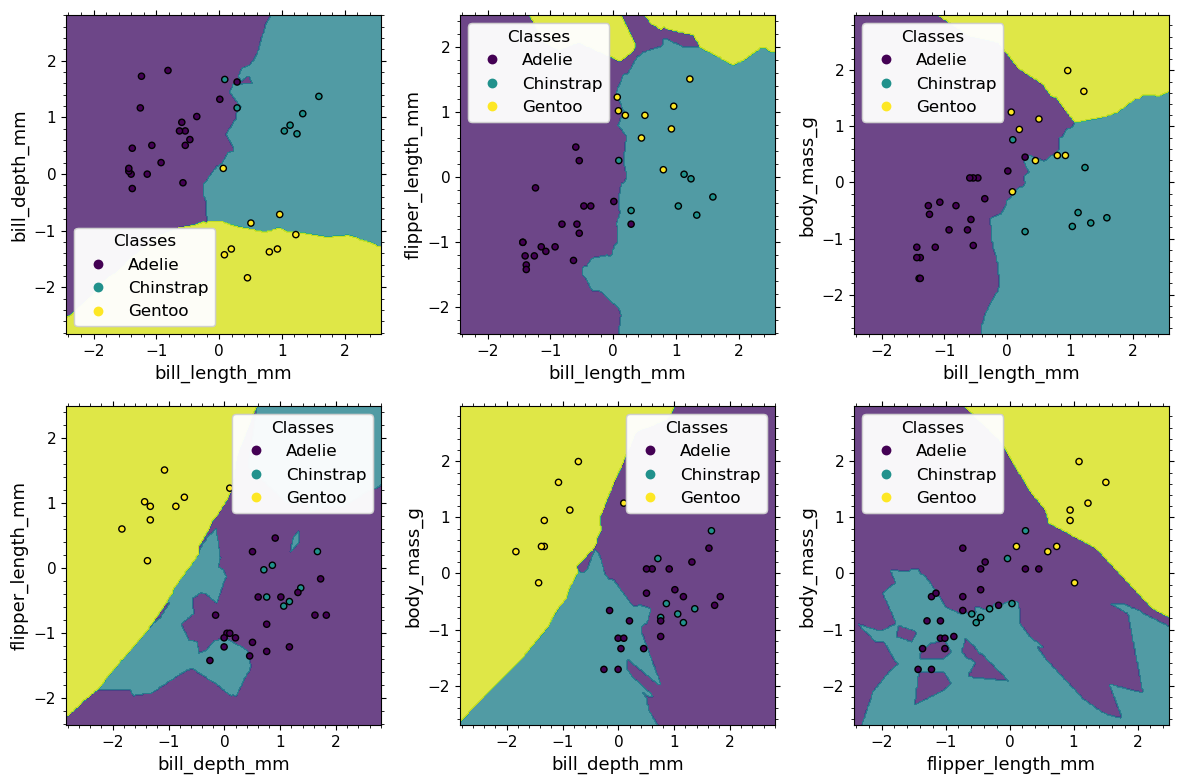

In [125]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], knn_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

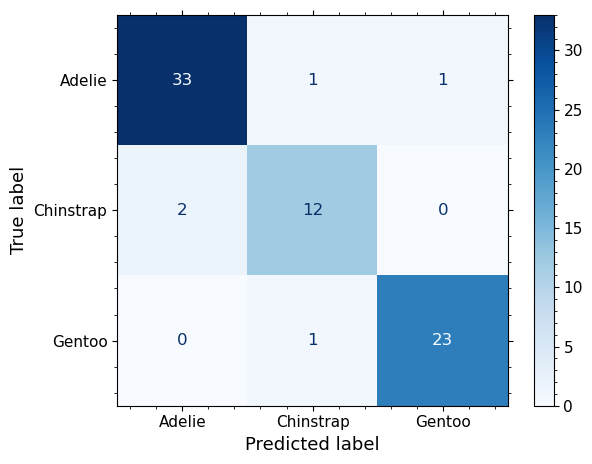

In [245]:
ConfusionMatrixDisplay.from_estimator(knn_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Support Vector Machine

In [246]:
svm_clf = SVC()
svm_cv = GridSearchCV(svm_clf, param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=5)
svm_cv.fit(X_train, y_train)
svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
svm_results

/tmp/ipykernel_5907/766811450.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002848,0.000741,0.001390,0.000520,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.913793,0.948276,0.931034,0.896552,0.894737,0.916878,0.020490,5.0
1,0.005502,0.000766,0.001735,0.000500,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.793103,0.810345,0.810345,0.793103,0.807018,0.802783,0.007996,15.0
2,0.004108,0.000648,0.001779,0.000694,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.931034,0.948276,0.948276,0.913793,0.894737,0.927223,0.020672,1.0
3,0.002507,0.000389,0.001122,0.000349,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",0.896552,0.948276,0.948276,0.931034,0.894737,0.923775,0.023823,3.0
4,0.002977,0.000705,0.001519,0.000246,1.0,poly,"{'C': 1.0, 'kernel': 'poly'}",0.896552,0.879310,0.879310,0.827586,0.877193,0.871990,0.023278,12.0
5,0.004470,0.001126,0.002481,0.001270,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.931034,0.948276,0.948276,0.913793,0.894737,0.927223,0.020672,1.0
6,0.004366,0.002366,0.001588,0.001119,10.0,linear,"{'C': 10.0, 'kernel': 'linear'}",0.879310,0.931034,0.965517,0.913793,0.894737,0.916878,0.029924,5.0
7,0.003383,0.001018,0.001330,0.000583,10.0,poly,"{'C': 10.0, 'kernel': 'poly'}",0.896552,0.896552,0.862069,0.913793,0.894737,0.892740,0.016834,10.0
8,0.002687,0.000716,0.000960,0.000447,10.0,rbf,"{'C': 10.0, 'kernel': 'rbf'}",0.896552,0.965517,0.948276,0.913793,0.877193,0.920266,0.032532,4.0
9,0.009043,0.002236,0.000766,0.000243,100.0,linear,"{'C': 100.0, 'kernel': 'linear'}",0.879310,0.913793,0.965517,0.913793,0.877193,0.909921,0.032028,7.0


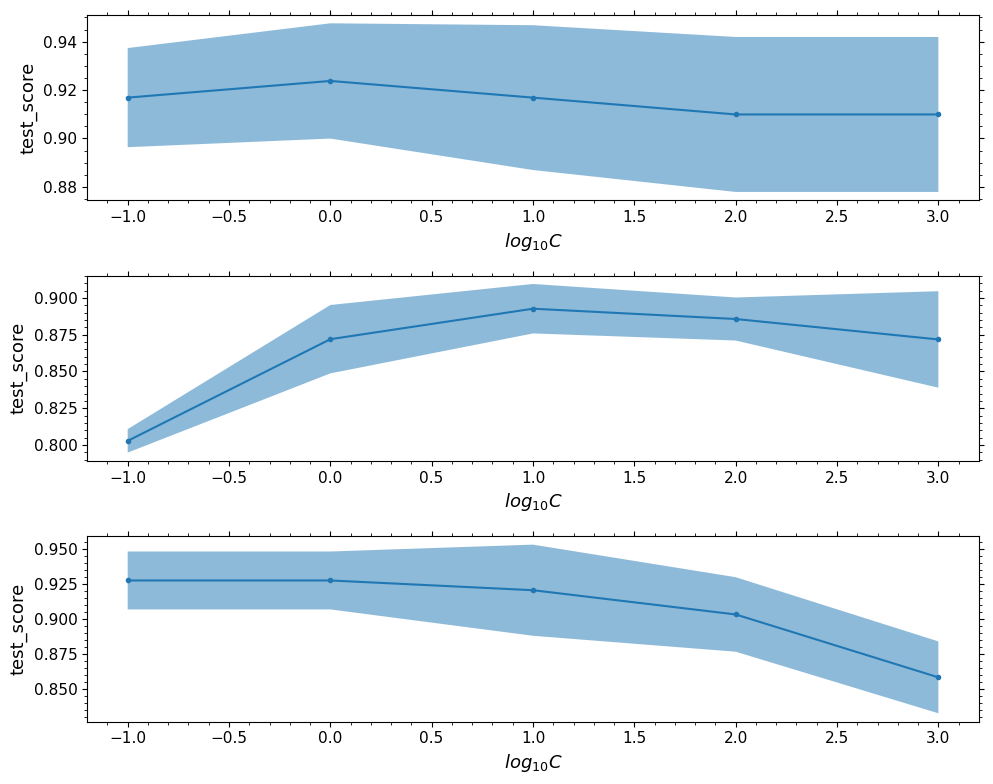

In [247]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))
for idx, kernel in enumerate(["linear", "poly", "rbf"]):
    svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
    ax[idx].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
    ax[idx].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                    svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
    ax[idx].set_xlabel("$log_{10} C$")
    ax[idx].set_ylabel("test_score")
    ax[idx].set_title("")
plt.show()

In [248]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], svm_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

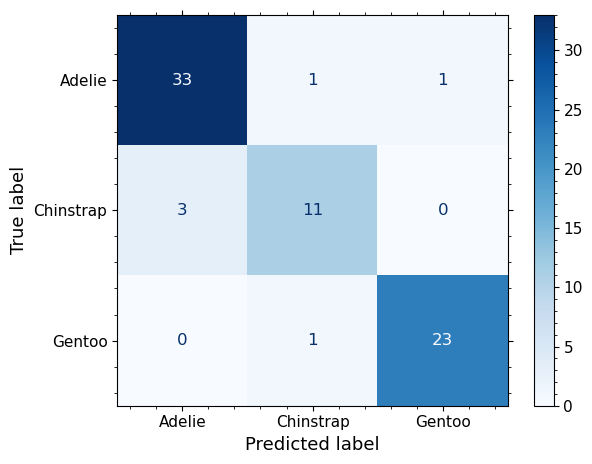

In [212]:
ConfusionMatrixDisplay.from_estimator(svm_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Linear Discriminant Analysis

In [190]:
lda_clf = LinearDiscriminantAnalysis()
lda_cv = GridSearchCV(lda_clf, param_grid={}, cv=5)
lda_cv.fit(X_train, y_train)
lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")
lda_results

/tmp/ipykernel_5907/2525302351.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0027,0.000601,0.00153,0.00108,{},0.938462,0.938462,0.953846,0.938462,0.892308,0.932308,0.020869,1.0


In [191]:
lda_cv.best_estimator_.intercept_

array([-2.62820248, -4.90635858, -4.75994571])

In [192]:
lda_cv.best_estimator_.coef_

array([[-2.35826064,  1.88731559, -0.5986576 , -0.1621443 ],
       [ 4.29448308,  1.38371149, -1.59162934, -3.36488981],
       [ 0.40640212, -3.10954728,  1.65214263,  2.14200093]])

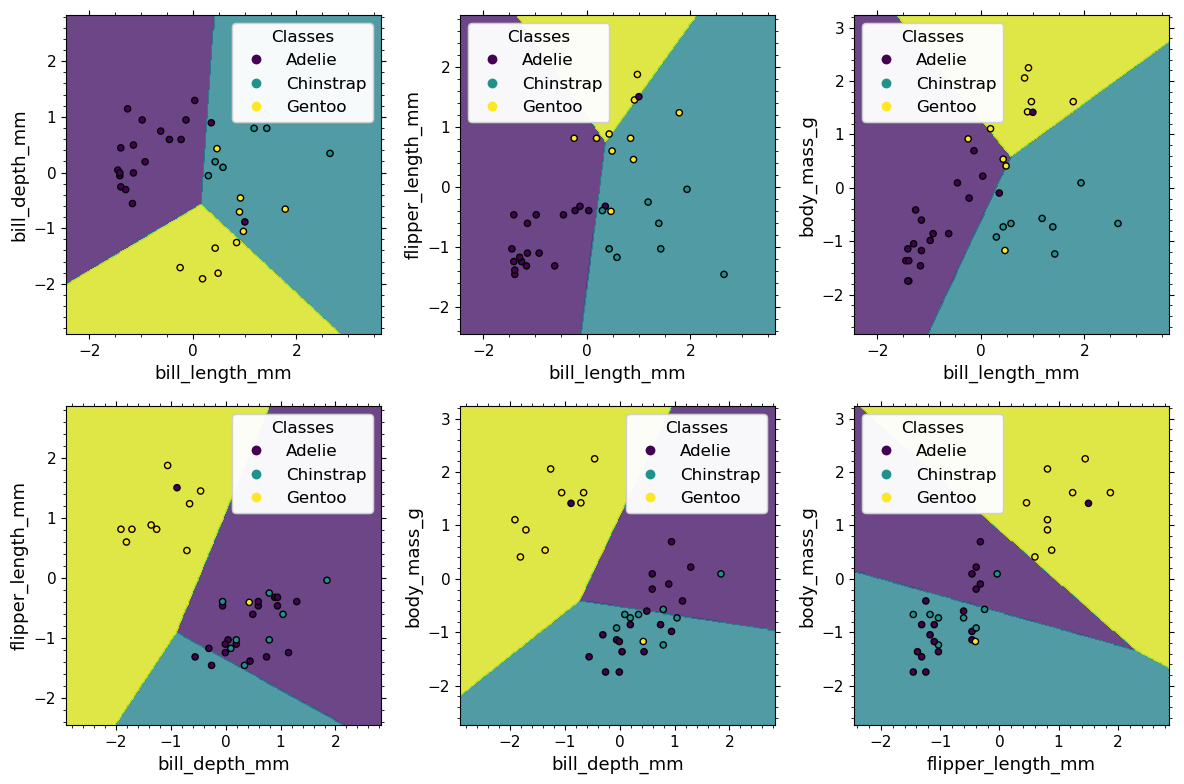

In [193]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

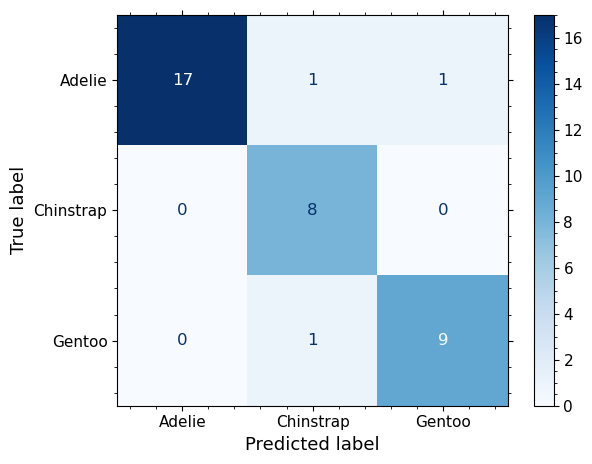

In [194]:
ConfusionMatrixDisplay.from_estimator(lda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Quadratic Discriminant Analysis

In [69]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_cv = GridSearchCV(qda_clf, param_grid={}, cv=5)
qda_cv.fit(X_train, y_train)
qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")
qda_results

/tmp/ipykernel_5907/1998898688.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003627,0.001483,0.002219,0.001165,{},0.953125,0.920635,0.984127,0.936508,0.952381,0.949355,0.021082,1.0


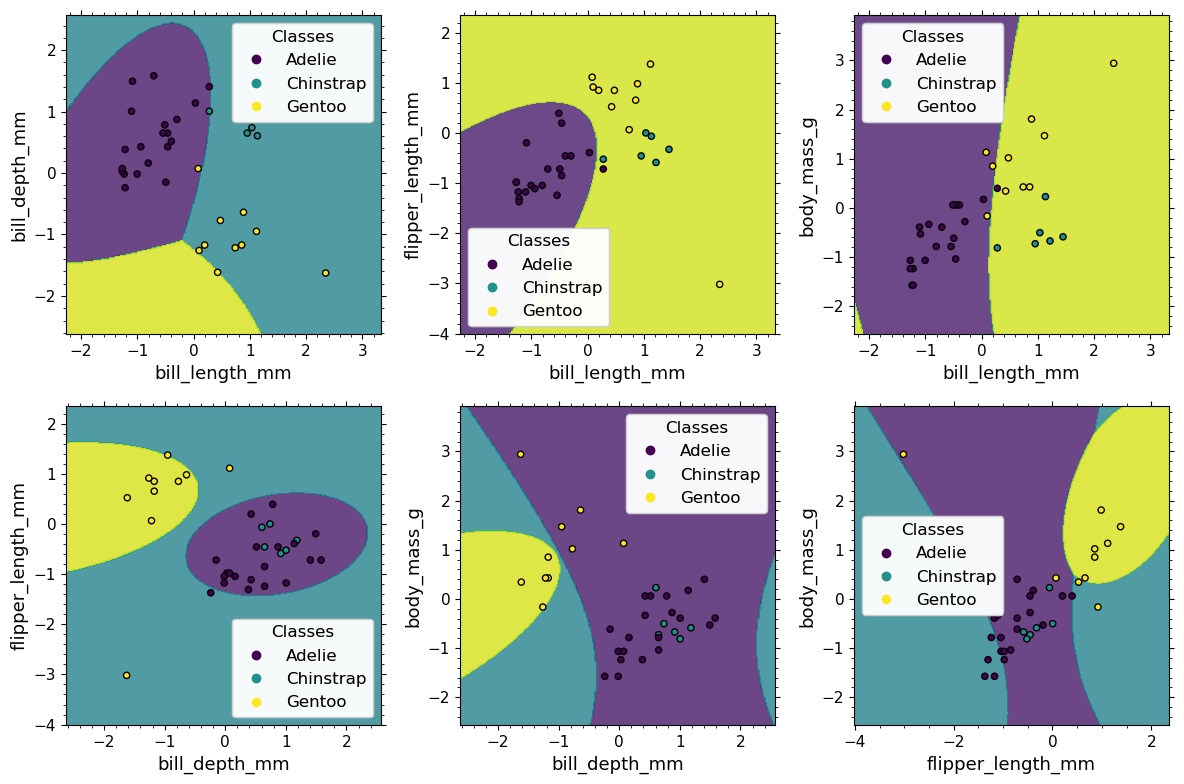

In [70]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], qda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

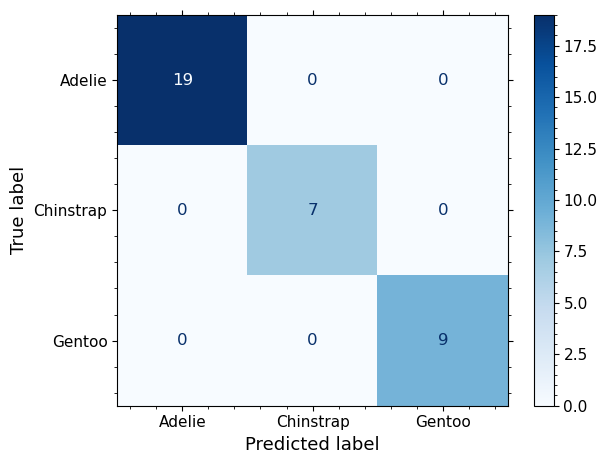

In [ ]:
ConfusionMatrixDisplay.from_estimator(qda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()